> ### EEE4423: Signal Processing Lab

# LAB \#3: CNN: VGG Net and ResNet [CoLab]

<div style="text-align: right"> Please upload your file in the form of [ID_Name_Lab3.ipynb]. </div></h4>

### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span> 
- Each team must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).

<h2><span style="color:blue">2014142243 Cha, Hyunsoo</span> </h2>

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2021-03-23 22:01:08.796723


In [2]:
#####################################################################
# In order to use GPU acceleration, you must change runtime type.
# See the menu bar above. 
# "Runtime" -> "Change runtime type"  -> "Hardware accelerator"
# Change 'None' to 'GPU', then run the code below.
#####################################################################

import sys
import platform
import torch
import time

print("Python version")
print(sys.version_info)

print("\nOS information")
print(platform.platform())

print("\nIs GPU available?")
print(torch.cuda.is_available())

# print("\nCPU information")
# !cat /proc/cpuinfo

# print("\nMemory information")
# !cat /proc/meminfo

print("\nGPU information")
!nvidia-smi

Python version
sys.version_info(major=3, minor=8, micro=8, releaselevel='final', serial=0)

OS information
Linux-5.8.0-45-generic-x86_64-with-glibc2.10

Is GPU available?
True

GPU information
Tue Mar 23 22:01:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.39       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:01:00.0  On |                  N/A |
| 58%   59C    P8    45W / 350W |  12558MiB / 24265MiB |     15%      Default |
|                               |                      

## 1. VGGNet with PyTorch

### Implementing VGGNet

> 1. **Dataset**
>> - Images from the first three categories in CIFAR-10(32x32). (Due to the computational constraints.)  <br>
     Three categories : plane, car, bird  /  The number of training images : 15,000   /  The number of test images : 3,000
>> - Augmented with flipping and random cropping(Data 늘리기).
>
> 2. **Network architecture**
>> - Type-D configuration in the paper (+ 3-way classifier after convolutional layers).
>> - ReLU activation.
>> - No dropout for simplicity.
>> - We will apply **batch-normalization** after every convolution which is not used in the paper (otherwise, hard to optimize).
>>
>> <table><tr>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1OiTmrplD9gOrEJizLChyLp31R0QtoeHv" alt="no_image" style="width: 550px;"/> </td>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1bBvAOdJeskMMyOrZtBCCnkEEgq9PgjX9" alt="no_image" style="width: 250px;"/> </td>
>> </tr></table>
>>
>> <font size="0.5"> Figure from <br>
>> [1] https://www.quora.com/What-is-the-VGG-neural-network </font>
>
> 3. **Loss function**
>> - Cross-entropy loss between outputs & ground-truths. <br>
     Note that `nn.CrossEntroyLoss` takes logits before softmax as network outputs and scalar index (not one-hot vector) as ground-truths.<br>
     See https://pytorch.org/docs/stable/nn.html#crossentropyloss for details.
>
> 4. **Training**
>> - Default weight initialization for simplicity.
>> - SGD optimizer with `learning rate = 1e-2`, `momentum = 0.9`, and `weight_decay = 5e-4`.
>> - 20 epochs without learning rate scheduling.
>
> 5. **Evaluation metric**
>> - Classification accuracy (i.e., the percentage of correct predictions).
>
> 

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets 
import torchvision
import time
import os

# os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
print('STEP 1: LOADING DATASET')

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),#Data Argument
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), #Torch의 Tensor 자료형으로 바꿔서 연산을 간편하게 한다.
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = dsets.CIFAR10(root='./data/CIFAR10/', 
                            train=True, 
                            transform=transform_train,
                            download=True)

test_dataset = dsets.CIFAR10(root='./data/CIFAR10/', 
                           train=False, 
                           transform=transform_test)

STEP 1: LOADING DATASET
Files already downloaded and verified


In [5]:
# reducing the dataset
reduced_train_dataset = []
for images, labels in train_dataset:
    if labels < 3:
        reduced_train_dataset.append((images, labels))
        
reduced_test_dataset = []
for images, labels in test_dataset:
    if labels < 3:
        reduced_test_dataset.append((images, labels))

In [6]:
print("The number of training images : ", len(reduced_train_dataset))
print("The number of test images : ", len(reduced_test_dataset))

The number of training images :  15000
The number of test images :  3000


In [7]:
print('STEP 2: MAKING DATASET ITERABLE')

train_loader = torch.utils.data.DataLoader(dataset=reduced_train_dataset, 
                                           batch_size=128, 
                                           shuffle=True) #Shuffle을 해야 성능이 올라간다

test_loader = torch.utils.data.DataLoader(dataset=reduced_test_dataset, 
                                          batch_size=100, 
                                          shuffle=False)

class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

STEP 2: MAKING DATASET ITERABLE


### Visualize a few images

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

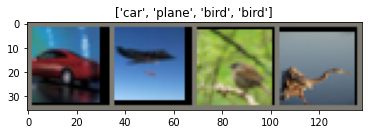

In [10]:
train_loader_sample = torch.utils.data.DataLoader(dataset=reduced_train_dataset, 
                                           batch_size=4, 
                                           shuffle=True)

# Get a batch of training data
inputs, classes = next(iter(train_loader_sample))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### 1.1 Write code (VGG 16) [3 points]

In [11]:
print('STEP 3: CREATE MODEL CLASS (VGG16)')

class VGG(nn.Module): # The beginning of the VGG16 network class.
    def __init__(self):
        super(VGG, self).__init__()

        # Convolution 1 (3x3, 64). This convolutional network consist of two conv layers.
        self.conv1_x = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn1_x = nn.BatchNorm2d(64) # BatchNorm should be fronted of ReLU function
        self.relu1_x = nn.ReLU()
        self.conv1_1_x = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn1_1_x = nn.BatchNorm2d(64)
        self.relu1_1_x = nn.ReLU()
        # Max pool 1, stride value should be 2 because of the reduction of dimension.
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # stride value should be 1 because of matching of the dimension
        # Convolution 2 (3x3, 128) times 2
        self.conv2_x = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn2_x = nn.BatchNorm2d(128)
        self.relu2_x = nn.ReLU()
        self.conv2_1_x = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn2_1_x = nn.BatchNorm2d(128)
        self.relu2_1_x = nn.ReLU()
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Convolution 3 (3x3, 256) times 3
        self.conv3_x = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn3_x = nn.BatchNorm2d(256)
        self.relu3_x = nn.ReLU()
        self.conv3_1_x = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn3_1_x = nn.BatchNorm2d(256)
        self.relu3_1_x = nn.ReLU()
        self.conv3_2_x = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn3_2_x = nn.BatchNorm2d(256)
        self.relu3_2_x = nn.ReLU()
        # Max pool 3
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Convolution 4 (3x3, 512) times 3
        self.conv4_x = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn4_x = nn.BatchNorm2d(512)
        self.relu4_x = nn.ReLU()
        self.conv4_1_x = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn4_1_x = nn.BatchNorm2d(512)
        self.relu4_1_x = nn.ReLU()
        self.conv4_2_x = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn4_2_x = nn.BatchNorm2d(512)
        self.relu4_2_x = nn.ReLU()
        # Max pool 4
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Convolution 5 (3x3, 512) times 3
        self.conv5_x = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn5_x = nn.BatchNorm2d(512)
        self.relu5_x = nn.ReLU()
        self.conv5_1_x = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn5_1_x = nn.BatchNorm2d(512)
        self.relu5_1_x = nn.ReLU()
        self.conv5_2_x = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn5_2_x = nn.BatchNorm2d(512)
        self.relu5_2_x = nn.ReLU()
        # Max pool 5
        self.maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected 1. Input features could be 512 after the calculation of layers. 
        # Output features could be 10 because of the fully-connected layers.
        self.fc1 = nn.Linear(in_features=512, out_features=10) 

    def forward(self, x):
        # Same structure as upper init function.
        # Convolution 1
        out = self.conv1_x(x)
        out = self.bn1_x(out)
        out = self.relu1_x(out)
        out = self.conv1_1_x(out) 
        out = self.bn1_1_x(out)
        out = self.relu1_1_x(out)
        # Max pool 1
        out = self.maxpool1(out)
        
        # Convolution 2
        out = self.conv2_x(out)
        out = self.bn2_x(out)
        out = self.relu2_x(out)
        out = self.conv2_1_x(out) 
        out = self.bn2_1_x(out)
        out = self.relu2_1_x(out)
        # Max pool 2
        out = self.maxpool2(out)
        
        # Convolution 3
        out = self.conv3_x(out)
        out = self.bn3_x(out)
        out = self.relu3_x(out)
        out = self.conv3_1_x(out) 
        out = self.bn3_1_x(out)
        out = self.relu3_1_x(out)
        out = self.conv3_2_x(out) 
        out = self.bn3_2_x(out)
        out = self.relu3_2_x(out)
        # Max pool 3
        out = self.maxpool3(out)
        
        # Convolution 4
        out = self.conv4_x(out)
        out = self.bn4_x(out)
        out = self.relu4_x(out)
        out = self.conv4_1_x(out) 
        out = self.bn4_1_x(out)
        out = self.relu4_1_x(out)
        out = self.conv4_2_x(out) 
        out = self.bn4_2_x(out)
        out = self.relu4_2_x(out)
        # Max pool 4
        out = self.maxpool4(out)
        
        # Convolution 5
        out = self.conv5_x(out)
        out = self.bn5_x(out)
        out = self.relu5_x(out)
        out = self.conv5_1_x(out) 
        out = self.bn5_1_x(out)
        out = self.relu5_1_x(out)
        out = self.conv5_2_x(out) 
        out = self.bn5_2_x(out)
        out = self.relu5_2_x(out)
        # Max pool 5
        out = self.maxpool5(out)
        
        # Tensor view prevent extra data copying. This makes fast with memory efficient.
        # Change size (100, 512, 3, 3) to (100, 512*4*3)
        out = out.view(out.size(0), -1) # out.size(0) == 100

        # Linear function (readout)
        out = self.fc1(out)
        return out

STEP 3: CREATE MODEL CLASS (VGG16)


In [12]:
print('STEP 4: INSTANTIATE MODEL CLASS')

model = VGG()
num_total_params = sum(p.numel() for p in model.parameters())
print("The number of parameters : ", num_total_params)
#######################
#  USE GPU FOR MODEL  #
#######################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
images.to(device)

STEP 4: INSTANTIATE MODEL CLASS
The number of parameters :  14728266


tensor([[[-1.0140, -0.5293, -0.5100,  ...,  0.1879,  0.1879,  1.5061],
         [-1.0915, -0.8007, -1.1109,  ..., -0.7813, -1.0527, -0.1029],
         [-1.0915, -0.6844, -1.2272,  ..., -0.9946, -1.4017, -1.2272],
         ...,
         [-0.0447,  0.1297,  0.0716,  ..., -0.3355, -1.2272, -1.9057],
         [-0.1998, -0.0447,  0.0716,  ..., -0.1998, -1.1497, -1.9057],
         [-0.1804, -0.0835,  0.0716,  ..., -0.1804, -1.1109, -1.9057]],

        [[-0.8842, -0.3926, -0.3336,  ...,  0.5318,  0.5121,  1.8101],
         [-0.9826, -0.6679, -0.9432,  ..., -0.5499, -0.8056,  0.1974],
         [-0.9826, -0.5499, -1.0219,  ..., -0.8252, -1.1989, -0.9629],
         ...,
         [ 0.0991,  0.1778,  0.0991,  ..., -0.3139, -1.2382, -1.8873],
         [-0.0386,  0.0204,  0.0598,  ..., -0.1369, -1.1399, -1.8873],
         [-0.0582, -0.0189,  0.0991,  ..., -0.1566, -1.1399, -1.9069]],

        [[-0.7581, -0.0167,  0.0028,  ...,  0.7442,  0.7832,  2.1294],
         [-0.8557, -0.3289, -0.6411,  ..., -0

In [13]:
print('STEP 5: INSTANTIATE LOSS CLASS')

criterion = nn.CrossEntropyLoss()

print('STEP 6: INSTANTIATE OPTIMIZER CLASS')

learning_rate = 1e-2
momentum = 0.9
weight_decay = 5e-4

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = momentum, weight_decay = weight_decay)

STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS


### 1.2 Train the VGG 16 model and print test accuracy for every epochs [2 points]

In [14]:
print('STEP 7: TRAIN THE MODEL')
num_epochs = 20 # 20 epoches
iter = 0
currection = 0
for epoch in range(num_epochs):
    start = time.time() # To measure the elapsed time.
    # Iteration in train set.
    for i, (images, labels) in enumerate(train_loader):
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        images = images.to(device) # To give data CUDA
        labels = labels.to(device)
        # Set gradients w.r.t. parameters
        optimizer.zero_grad()
        # To give the input (images) to VGG16 network. Calculation.
        outputs = model(images)
        # (Step 5) Loss function is cross entropy function.
        loss = criterion(outputs, labels)
        # Get gradients with parameters
        loss.backward()
        # Updating parameters
        optimizer.step()  
        correct = 0
        total = 0
        # Iteration in test dataset
        for images, labels in test_loader:
            # Same as upper code.
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            # Get predictions from the maximum value
            _, predicted = torch.max(outputs.data, 1)
            # Add all of the numbers of labels.
            total += labels.size(0)
            #######################
            #  USE GPU FOR MODEL  #
            #######################
            # Calculate the prediction by using CPU not CUDA
            if torch.cuda.is_available():
                correct += (predicted.cpu() == labels.cpu()).sum()
            else:
                correct += (predicted == labels).sum()    
    accuracy = 100 * correct.item() / total
    end = time.time() # Finishing the elapsed time.
    print('Epoch: {}. Loss: {}. Accuracy: {}. Elapsed Time: {} sec'.format(epoch, loss.item(), accuracy, end-start))

STEP 7: TRAIN THE MODEL
Epoch: 0. Loss: 0.5250886082649231. Accuracy: 82.23333333333333. Elapsed Time: 22.34292984008789 sec
Epoch: 1. Loss: 0.5068008303642273. Accuracy: 85.33333333333333. Elapsed Time: 21.986222743988037 sec
Epoch: 2. Loss: 0.4354035556316376. Accuracy: 86.4. Elapsed Time: 22.13666009902954 sec
Epoch: 3. Loss: 0.10350047796964645. Accuracy: 88.7. Elapsed Time: 22.25410509109497 sec
Epoch: 4. Loss: 0.2555007040500641. Accuracy: 89.46666666666667. Elapsed Time: 22.41740918159485 sec
Epoch: 5. Loss: 0.11140909790992737. Accuracy: 89.53333333333333. Elapsed Time: 22.52353525161743 sec
Epoch: 6. Loss: 0.07933221012353897. Accuracy: 87.76666666666667. Elapsed Time: 22.574379920959473 sec
Epoch: 7. Loss: 0.09420273452997208. Accuracy: 90.5. Elapsed Time: 22.380926370620728 sec
Epoch: 8. Loss: 0.14247746765613556. Accuracy: 89.4. Elapsed Time: 22.962148666381836 sec
Epoch: 9. Loss: 0.10326573997735977. Accuracy: 90.06666666666666. Elapsed Time: 22.649141788482666 sec
Epoch: 

## 2. ResNet with PyTorch

### Implementing ResNet

> 1. **Dataset**
>> - The same dataset used for VGGNet
>
> 2. **Network architecture**
>> - 50-layer ResNet with **bottleneck blocks**.<br>
     Note. The initial convolution layer (i.e., conv1) is different from the one in the paper &<br>
     the initial max-pooling layer is removed (because the size of CIFAR-10 images is too small).
>> - ReLU activation.
>> - Strided convolution for down-sampling instead of max-pooling layer. <br>
     Note. Once down-sampled, a $1\times1$ convolution/stride 2 is applied to residual for expanding the channel of the residual.
>> - No dropout for simplicity.
>> - Batch-normalization after every convolution.
>>
>>
>> <table><tr>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1ZYDfpVBFBvQnVezVcJqRxwh09rUVmxwD" alt="no_image" style="width: 500px;"/> </td>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1JNEea1G-5yOKVLmSCkiYAEJ0HXOys0CR" alt="no_image" style="width: 300px;"/> </td>
>> </tr></table>
>>
>> <img src="https://docs.google.com/uc?export=download&id=1vY0ys5KAZmMlOKk8Dcv7eAV8pZ9cawzJ" alt="no_image" style="width: 870px;"/>
>>
>> <font size="0.5"> Figures from <br> 
>> [1] https://www.codeproject.com/Articles/1248963/Deep-Learning-using-Python-plus-Keras-Chapter-Re  <br> 
>> [2] Rezende et al., *Signal Processing: Image Communication*, 2018. </font>
>
> 3. **Loss function**
>> - Cross-entropy loss between outputs & ground-truths. <br>
>
> 4. **Training**
>> - Default weight initialization for simplicity.
>> - SGD optimizer with `learning rate = 1e-2`, `momentum = 0.9`, and `weight_decay = 5e-4`.
>> - 15 epochs without learning rate scheduling.
>
> 5. **Evaluation metric**
>> - Classification accuracy (i.e., the percentage of correct predictions).

### 2.1 Implement ResNet50 and train it with the CIFAR 10 dataset [4 points] 

In [15]:
print('STEP 3: CREATE MODEL CLASS (ResNet-50)')

class Unit_Normal(nn.Module): # Normal Unit class for non-shortcut connection block
    def __init__(self, in_v, out_v): # Parameters are input value and output value.
        super(Unit_Normal, self).__init__()
        self.normal = nn.Sequential(
            nn.Conv2d(in_channels=out_v, out_channels=in_v, kernel_size=1, bias=False),# kernel_size=1x1 with no bias
            nn.BatchNorm2d(num_features=in_v),
            nn.ReLU(), # Similar as VGG16
            
            nn.Conv2d(in_v, in_v, kernel_size=3, padding=1, bias=False), #3x3 filters with no bias
            nn.BatchNorm2d(in_v),
            nn.ReLU(),
            
            nn.Conv2d(in_v, out_v, kernel_size=1, bias=False), #1x1
            nn.BatchNorm2d(out_v) # All of the networks have output values which is more than 4 times input value
        )
        self.line = nn.Sequential() # No colvolution network. For same tensor.
        
    def forward(self, x):
        # After the image passes with Normal and Line, it is finally merged into the ReLU function and passed.
        out = nn.ReLU()(self.normal(x) + self.line(x))
        return out
    
class Unit_BottleNeck(nn.Module): # Bottle Neck class for shortcut connection block.
    def __init__(self, in_v, out_v, stride_v, dim): # Add dim parameter for matching same dimensions between layers.
        super(Unit_BottleNeck, self).__init__()
        self.bottleneck = nn.Sequential(
            # The reason for multiplying the input value by the dim value is to match the dimension in the preceding layer. 
            # For example, before conv3_x, 256 dimensions are created. 
            # For conv2d layer of conv3_x layer, it shall have 256 for the conv2d layer. 
            # This process of downsampling can reduce the loss of information unlike maxpooling.
            # Stride value should be 2 in front of the bottlenect layers.
            nn.Conv2d(in_channels=int(in_v*dim), out_channels=in_v, stride=stride_v, kernel_size=1, bias=False),# kernel_size=1x1
            nn.BatchNorm2d(num_features=in_v),
            nn.ReLU(),
            
            nn.Conv2d(in_v, in_v, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(in_v),
            nn.ReLU(),
            
            nn.Conv2d(in_v, out_v, kernel_size=1, bias=False), # 1x1 kernel size.
            nn.BatchNorm2d(out_v)
        )
        # BottleNeck Connection.
        # To match the dimension with front layer's, I set the calculation with input value times dim parameter.
        self.dot = nn.Sequential(
            nn.Conv2d(int(in_v*dim), out_v, stride=stride_v, kernel_size=1, bias=False), # 1x1 Filter, based on paper, stride is 2
            nn.BatchNorm2d(out_v)
        )
    # Similar to Unit_Normal Class
    def forward(self, x):
        out = nn.ReLU()(self.bottleneck(x) + self.dot(x))
        return out
    
class Resnet50(nn.Module):
    def __init__(self):
        super(Resnet50, self).__init__()
        # No max pooling. Only used 1x1 convolution filter with stride 2 except conv2_x.
        self.conv1 = nn.Sequential(
            # Set the conv1 layer with stride 1 3x3 filter by 64 dimensions.
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, bias=False),# 3x3 Filter(Kernel Size)
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        # three unit blocks.
        self.conv2_x = nn.Sequential(
            Unit_BottleNeck(64, 256, 1, dim=1), # Only conv2_x has 1 dim parameter because of the size (32x32 image is too small)
            Unit_Normal(64, 256),
            Unit_Normal(64, 256)
        )
        # four unit blocks
        self.conv3_x = nn.Sequential(
            Unit_BottleNeck(128, 512, 2, dim=2), # After the conv3_x, parameter dim has 2 for matching.
            Unit_Normal(128, 512),
            Unit_Normal(128, 512),
            Unit_Normal(128, 512)
        )
        # six unit blocks
        self.conv4_x = nn.Sequential(
            Unit_BottleNeck(256, 1024, 2, dim=2),
            Unit_Normal(256, 1024),
            Unit_Normal(256, 1024),
            Unit_Normal(256, 1024),
            Unit_Normal(256, 1024),
            Unit_Normal(256, 1024)
        )
        # three unit blocks
        self.conv5_x = nn.Sequential(
            Unit_BottleNeck(512, 2048, 2, dim=2),
            Unit_Normal(512, 2048),
            Unit_Normal(512, 2048)
        )
        # average pooling with 1x1 size
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        # fully-connected layer with 2048 to 100.
        self.fc = nn.Linear(512 * 4, 100)

    def forward(self, x):
        # Same structure init function.
        out = self.conv1(x)
        out = self.conv2_x(out)
        out = self.conv3_x(out)
        out = self.conv4_x(out)
        out = self.conv5_x(out)
        
        out = self.avg_pool(out)
        
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out

STEP 3: CREATE MODEL CLASS (ResNet-50)


In [16]:
print('STEP 4: INSTANTIATE MODEL CLASS')

model = Resnet50()
num_total_params = sum(p.numel() for p in model.parameters())
print("The number of parameters : ", num_total_params)
#######################
#  USE GPU FOR MODEL  #
#######################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
images.to(device)

STEP 4: INSTANTIATE MODEL CLASS
The number of parameters :  23705252


tensor([[[[-2.1964e+00, -2.3321e+00, -2.3903e+00,  ..., -1.1690e+00,
           -1.2078e+00, -1.1109e+00],
          [-1.8863e+00, -2.0026e+00, -2.0801e+00,  ..., -9.9458e-01,
           -9.5581e-01, -8.7827e-01],
          [ 1.3434e-02, -4.3242e-01, -8.7827e-01,  ..., -7.2319e-01,
           -6.4565e-01, -5.8750e-01],
          ...,
          [-2.3857e-01, -3.3549e-01, -4.1303e-01,  ..., -5.8750e-01,
           -5.2934e-01, -5.0996e-01],
          [-1.6103e-01, -3.3549e-01, -4.5180e-01,  ..., -5.8750e-01,
           -5.4873e-01, -5.0996e-01],
          [-2.1919e-01, -3.5488e-01, -3.7426e-01,  ..., -5.4873e-01,
           -5.0996e-01, -4.5180e-01]],

         [[ 2.7610e-01,  2.5644e-01,  2.3677e-01,  ...,  6.6944e-01,
            6.8911e-01,  6.8911e-01],
          [ 2.0434e-02,  9.9101e-02,  1.7777e-01,  ...,  7.4811e-01,
            8.0711e-01,  8.0711e-01],
          [ 7.2844e-01,  4.5310e-01,  2.3677e-01,  ...,  7.8744e-01,
            8.8578e-01,  8.8578e-01],
          ...,
     

### 2.2 Print test accuracy for every epochs. [1 points]

In [17]:
print('STEP 5: INSTANTIATE LOSS CLASS')

criterion = nn.CrossEntropyLoss()

STEP 5: INSTANTIATE LOSS CLASS


In [18]:
print('STEP 6: INSTANTIATE OPTIMIZER CLASS')

learning_rate = 1e-2
momentum = 0.9
weight_decay = 5e-4

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = momentum, weight_decay = weight_decay)

STEP 6: INSTANTIATE OPTIMIZER CLASS


In [19]:
print('STEP 7: TRAIN THE MODEL')

# Same parameter, same structure, same code except a number of epoches (15)
# I will skip the annotation because it overlaps.
num_epochs = 15
iter = 0
currection = 0
for epoch in range(num_epochs):
    start = time.time()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()  
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            if torch.cuda.is_available():
                correct += (predicted.cpu() == labels.cpu()).sum()
            else:
                correct += (predicted == labels).sum()    
    accuracy = 100 * correct.item() / total
    end = time.time()
    print('Epoch: {}. Loss: {}. Accuracy: {}. Elapsed Time: {} sec'.format(epoch, loss.item(), accuracy, end-start))

STEP 7: TRAIN THE MODEL
Epoch: 0. Loss: 0.5044456124305725. Accuracy: 71.13333333333334. Elapsed Time: 112.27942514419556 sec
Epoch: 1. Loss: 0.4014207422733307. Accuracy: 77.6. Elapsed Time: 111.43979954719543 sec
Epoch: 2. Loss: 0.9349769949913025. Accuracy: 76.36666666666666. Elapsed Time: 112.00061273574829 sec
Epoch: 3. Loss: 0.7840763926506042. Accuracy: 81.56666666666666. Elapsed Time: 109.99552702903748 sec
Epoch: 4. Loss: 0.6339263319969177. Accuracy: 80.56666666666666. Elapsed Time: 109.96531772613525 sec
Epoch: 5. Loss: 0.5485923886299133. Accuracy: 79.2. Elapsed Time: 109.9623486995697 sec
Epoch: 6. Loss: 0.7427573800086975. Accuracy: 81.63333333333334. Elapsed Time: 110.00558686256409 sec
Epoch: 7. Loss: 0.2623394727706909. Accuracy: 82.2. Elapsed Time: 110.02319359779358 sec
Epoch: 8. Loss: 0.34514057636260986. Accuracy: 83.2. Elapsed Time: 110.04423379898071 sec
Epoch: 9. Loss: 0.14959801733493805. Accuracy: 82.4. Elapsed Time: 110.00772500038147 sec
Epoch: 10. Loss: 0.1

# Q. Report and discuss your results. Analyze the algorithm, theoretically and empirically.
* In this experiment, I implement and wrote VGG16 and Resnet50 directly. VGG16 consists largely of five convolutional layers, with 13 convolutional layers and Batch Normalization Function and ReLU Function following them. I wrote in the form of deliberately unfolding all layers to implement VGG 16. Through this, code was written with a more intuitive understanding. I think it was a great approach except for the disadvantage that most numbers are similar and confusing, which makes debugging too difficult. The result of VGG16 I made was 92.8% accuracy.
* In VGG networks, there is something to be careful about. Most activation functions have nonlinearities near zero. Thus, after batch normalization allows the data to be well distributed near zero, the method of applying nonlinearity is mainly used. In addition, if the values of location containing a lot of important information at the beginning of the learning take a negative value and pass through the ReLU and change to zero, gradient is zero and there is a possibility of delayed or unstable learning. Therefore, it is common for Batch Normalization functions to be used before ReLU.
* The second experiment is Resnet50 implementation. For Resnet50, it was too difficult to do 50 layers exactly like the way VGG16 was implemented. So, nn.Sequential() made simplified my code with readability, and based on the fact that Resnet50 has a common unit, it wanted to create two classes for the unit and implement them easily. The result was 86.13% accuracy as shown in the terminal.
* The phenomenal part of Resnet50 is that it does not stagnate in accuracy even though a considerable number of layers have been built. Although it is true that the accuracy is lower than that of VGG16, it can be meaningful to devise a shortcut method to create a network that learns more information without loss.
* The detailed description of the code I wrote is indicated by the code annotation.